#**DeepLearning CNN**

##Mengambil Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!unzip '/content/drive/My Drive/BIG DATA/COVID-20240519T113718Z-001.zip' -d /content/COVID/
!unzip '/content/drive/My Drive/BIG DATA/NORMAL-20240519T113718Z-001.zip' -d /content/NORMAL/

Archive:  /content/drive/My Drive/BIG DATA/COVID-20240519T113718Z-001.zip
replace /content/COVID/COVID/COVID_958.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/COVID/COVID/COVID_958.png  
  inflating: /content/COVID/COVID/COVID_968.png  
  inflating: /content/COVID/COVID/COVID_988.png  
  inflating: /content/COVID/COVID/COVID_985.png  
  inflating: /content/COVID/COVID/COVID_98.png  
  inflating: /content/COVID/COVID/COVID_974.png  
  inflating: /content/COVID/COVID/COVID_972.png  
  inflating: /content/COVID/COVID/COVID_978.png  
  inflating: /content/COVID/COVID/COVID_960.png  
  inflating: /content/COVID/COVID/COVID_980.png  
  inflating: /content/COVID/COVID/COVID_961.png  
  inflating: /content/COVID/COVID/COVID_992.png  
  inflating: /content/COVID/COVID/COVID_997.png  
  inflating: /content/COVID/COVID/COVID_986.png  
  inflating: /content/COVID/COVID/COVID_993.png  
  inflating: /content/COVID/COVID/COVID_991.png  
  inflating: /content/COVID/COVID/COVID_96.

##Membuat Directory Baru

In [10]:
import os
import shutil
import numpy as np

# Membuat base directory
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Membuat subdirectory untuk NORMAL dan COVID
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_covid_dir = os.path.join(train_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_covid_dir = os.path.join(validation_dir, 'COVID')

os.makedirs(train_normal_dir, exist_ok=True)
os.makedirs(train_covid_dir, exist_ok=True)
os.makedirs(validation_normal_dir, exist_ok=True)
os.makedirs(validation_covid_dir, exist_ok=True)

def split_data_with_limit(source_dir, train_dir, validation_dir, split_size=0.8, limit=20):
    all_files = os.listdir(source_dir)
    np.random.shuffle(all_files)
    split_index = int(len(all_files) * split_size)
    train_files = all_files[:split_index]
    validation_files = all_files[split_index:]

    # Ambil jumlah gambar yang diinginkan dari masing-masing kategori
    train_files = train_files[:min(len(train_files), limit)]
    validation_files = validation_files[:min(len(validation_files), limit)]

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), train_dir)

    for file in validation_files:
        shutil.copy(os.path.join(source_dir, file), validation_dir)

# Membagi data ke dalam training dan validation sets dengan batasan jumlah gambar 20
split_data_with_limit('/content/COVID/COVID', train_covid_dir, validation_covid_dir, limit=20)
split_data_with_limit('/content/NORMAL/NORMAL', train_normal_dir, validation_normal_dir, limit=20)


In [11]:
print(f"Total training NORMAL images: {len(os.listdir(train_normal_dir))}")
print(f"Total training COVID images: {len(os.listdir(train_covid_dir))}")
print(f"Total validation NORMAL images: {len(os.listdir(validation_normal_dir))}")
print(f"Total validation COVID images: {len(os.listdir(validation_covid_dir))}")


Total training NORMAL images: 40
Total training COVID images: 40
Total validation NORMAL images: 40
Total validation COVID images: 40


##Membuat Directory baru lagi dengan Nama Lain (Splitting)

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Membuat direktori baru untuk train dan test
new_base_dir = '/content/new_dataset'
new_train_dir = os.path.join(new_base_dir, 'train')
new_test_dir = os.path.join(new_base_dir, 'test')

os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

# Membuat sub-direktori untuk NORMAL dan COVID di train dan test
new_train_normal_dir = os.path.join(new_train_dir, 'NORMAL')
new_train_covid_dir = os.path.join(new_train_dir, 'COVID')
new_test_normal_dir = os.path.join(new_test_dir, 'NORMAL')
new_test_covid_dir = os.path.join(new_test_dir, 'COVID')

os.makedirs(new_train_normal_dir, exist_ok=True)
os.makedirs(new_train_covid_dir, exist_ok=True)
os.makedirs(new_test_normal_dir, exist_ok=True)
os.makedirs(new_test_covid_dir, exist_ok=True)

# Fungsi untuk memindahkan data ke direktori baru
def move_data(source_dir, target_dir, limit=None):
    all_files = os.listdir(source_dir)
    np.random.shuffle(all_files)
    if limit:
        all_files = all_files[:limit]
    for file in all_files:
        shutil.copy(os.path.join(source_dir, file), target_dir)

# Memindahkan data train dari direktori sebelumnya ke direktori baru
move_data(train_normal_dir, new_train_normal_dir)
move_data(train_covid_dir, new_train_covid_dir)
# Memindahkan data test dari direktori sebelumnya ke direktori baru
move_data(validation_normal_dir, new_test_normal_dir)
move_data(validation_covid_dir, new_test_covid_dir)

In [13]:
print(f"Total training NORMAL images: {len(os.listdir(new_train_normal_dir))}")
print(f"Total training COVID images: {len(os.listdir(new_train_covid_dir))}")
print(f"Total test NORMAL images: {len(os.listdir(new_test_normal_dir))}")
print(f"Total test COVID images: {len(os.listdir(new_test_covid_dir))}")

Total training NORMAL images: 40
Total training COVID images: 40
Total test NORMAL images: 40
Total test COVID images: 40


##Data augmentation dan normalisasi

In [14]:
# Data augmentation dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    new_train_dir,
    target_size=(150, 150),
    batch_size=20,  # Ubah batch_size menjadi 20
    class_mode='sparse',  # Gunakan class_mode='sparse'
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    new_test_dir,
    target_size=(150, 150),
    batch_size=20,  # Ubah batch_size menjadi 20
    class_mode='sparse',  # Gunakan class_mode='sparse'
    shuffle=False
)

# Mendefinisikan model CNN custom
def build_custom_cnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

input_shape = (150, 150, 3)
custom_cnn = build_custom_cnn(input_shape)

custom_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('custom_cnn_model.h5', monitor='val_loss', save_best_only=True)
]

history_custom_cnn = custom_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=callbacks
)

# Evaluasi model
val_loss_custom_cnn, val_acc_custom_cnn = custom_cnn.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc_custom_cnn:.4f}")

# Prediksi dan laporan klasifikasi
validation_generator.reset()
Y_pred_custom_cnn = custom_cnn.predict(validation_generator)
y_pred_custom_cnn = (Y_pred_custom_cnn > 0.5).astype(int).ravel()
print(classification_report(validation_generator.classes, y_pred_custom_cnn, target_names=['NORMAL', 'COVID']))


Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/10
4/4 [==============================] - 9s 2s/step - loss: 0.7633 - accuracy: 0.4875 - val_loss: 0.6840 - val_accuracy: 0.5000
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 9s 2s/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6753 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 0.6665 - accuracy: 0.5875 - val_loss: 0.6301 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.6395 - accuracy: 0.5750 - val_loss: 0.5302 - val_accuracy: 0.9125
Epoch 5/10
4/4 [==============================] - 10s 3s/step - loss: 0.6058 - accuracy: 0.6750 - val_loss: 0.5980 - val_accuracy: 0.6750
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 0.5270 - accuracy: 0.8000 - val_loss: 0.4220 - val_accuracy: 0.8625
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 0.4171 - accuracy: 0.8750 - val_loss: 0.3733 - val_accuracy: 0.8500
Epoch 8/10
4/4 [==============================] - 6s 2s/step - loss: 0.5231 - accuracy: 0.7125 - val_loss: 0.3092 - val_accuracy: 0.9500
Epoch 9/10
4/4 [==============================] - 7

#**ALEXNET**

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Define AlexNet model
def build_alexnet(input_shape):
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,  # Ubah batch_size menjadi 20
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,  # Ubah batch_size menjadi 20
    class_mode='binary'
)

# Build and compile AlexNet model
input_shape = (150, 150, 3)
alexnet = build_alexnet(input_shape)

alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('alexnet_model.h5', monitor='val_loss', save_best_only=True)
]

# Train AlexNet model
history_alexnet = alexnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=callbacks
)

# Evaluate AlexNet model
val_loss_alexnet, val_acc_alexnet = alexnet.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc_alexnet:.4f}")

# Predict and Classification Report for AlexNet
validation_generator.reset()
Y_pred_alexnet = alexnet.predict(validation_generator)
y_pred_alexnet = (Y_pred_alexnet > 0.5).astype(int).ravel()
print(classification_report(validation_generator.classes, y_pred_alexnet, target_names=['NORMAL', 'COVID']))


Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 1.0682 - accuracy: 0.4750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 14s 3s/step - loss: 1.0682 - accuracy: 0.4750 - val_loss: 0.7079 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 13s 3s/step - loss: 0.7332 - accuracy: 0.6250 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 14s 4s/step - loss: 0.6984 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 10s 3s/step - loss: 0.6949 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 12s 3s/step - loss: 0.6959 - accuracy: 0.4500 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 11s 3s/step - loss: 0.6975 - accuracy: 0.5000 - val_loss: 0.6826 - val_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 11s 3s/step - loss: 0.6813 - accuracy: 0.6000 - val_loss: 0.6793 - val_accuracy: 0.5000
Epoch 8/10
4/4 [=============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**VGG16**

In [15]:
from tensorflow.keras.applications import VGG16

# Define VGG16 model
def build_vgg16(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = tf.keras.Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile VGG16 model
vgg16 = build_vgg16(input_shape)

vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('vgg16_model.h5', monitor='val_loss', save_best_only=True)
]

# Train VGG16 model
history_vgg16 = vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=callbacks
)

# Evaluate VGG16 model
val_loss_vgg16, val_acc_vgg16 = vgg16.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc_vgg16:.4f}")

# Predict and Classification Report for VGG16
validation_generator.reset()
Y_pred_vgg16 = vgg16.predict(validation_generator)
y_pred_vgg16 = (Y_pred_vgg16 > 0.5).astype(int).ravel()
print(classification_report(validation_generator.classes, y_pred_vgg16, target_names=['NORMAL', 'COVID']))


Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 18.5336 - accuracy: 0.5750 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 127s 34s/step - loss: 18.5336 - accuracy: 0.5750 - val_loss: 0.7356 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 127s 35s/step - loss: 0.9408 - accuracy: 0.4375 - val_loss: 0.7201 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 120s 33s/step - loss: 0.7053 - accuracy: 0.5500 - val_loss: 0.8698 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 124s 35s/step - loss: 0.8453 - accuracy: 0.4625 - val_loss: 0.7564 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 118s 33s/step - loss: 0.7280 - accuracy: 0.4375 - val_loss: 0.6886 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 125s 35s/step - loss: 0.7138 - accuracy: 0.5500 - val_loss: 0.6730 - val_accuracy: 0.5625
Epoch 7/10
4/4 [==============================] - 118s 33s/step - loss: 0.6773 - accuracy: 0.5500 - val_loss: 0.6506 - val_accuracy: 0.8875
Epoch 8/10
4/4 [==============

4/4 [==============================] - 23s 6s/step
              precision    recall  f1-score   support

      NORMAL       1.00      0.07      0.14        40
       COVID       0.52      1.00      0.68        40

    accuracy                           0.54        80
   macro avg       0.76      0.54      0.41        80
weighted avg       0.76      0.54      0.41        80



#**Testing CNN model**

##Plotting Learning Curves, Confussion Matrix and Displaying those images that were wrongly classified

---



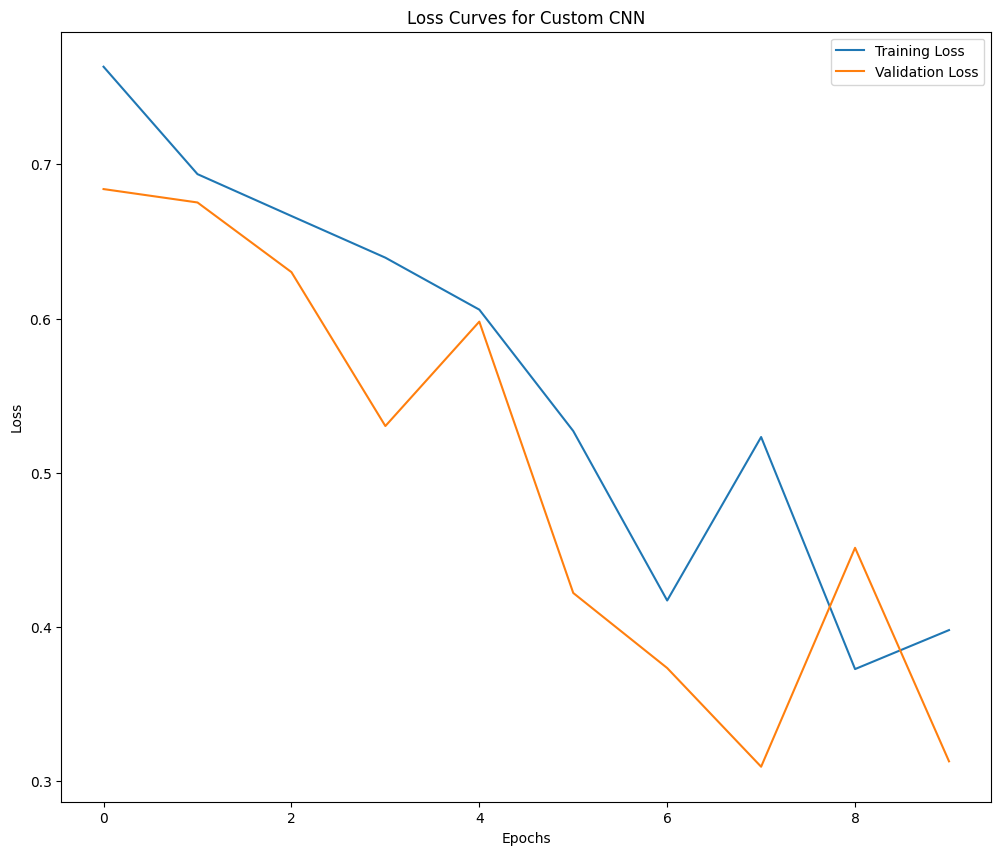

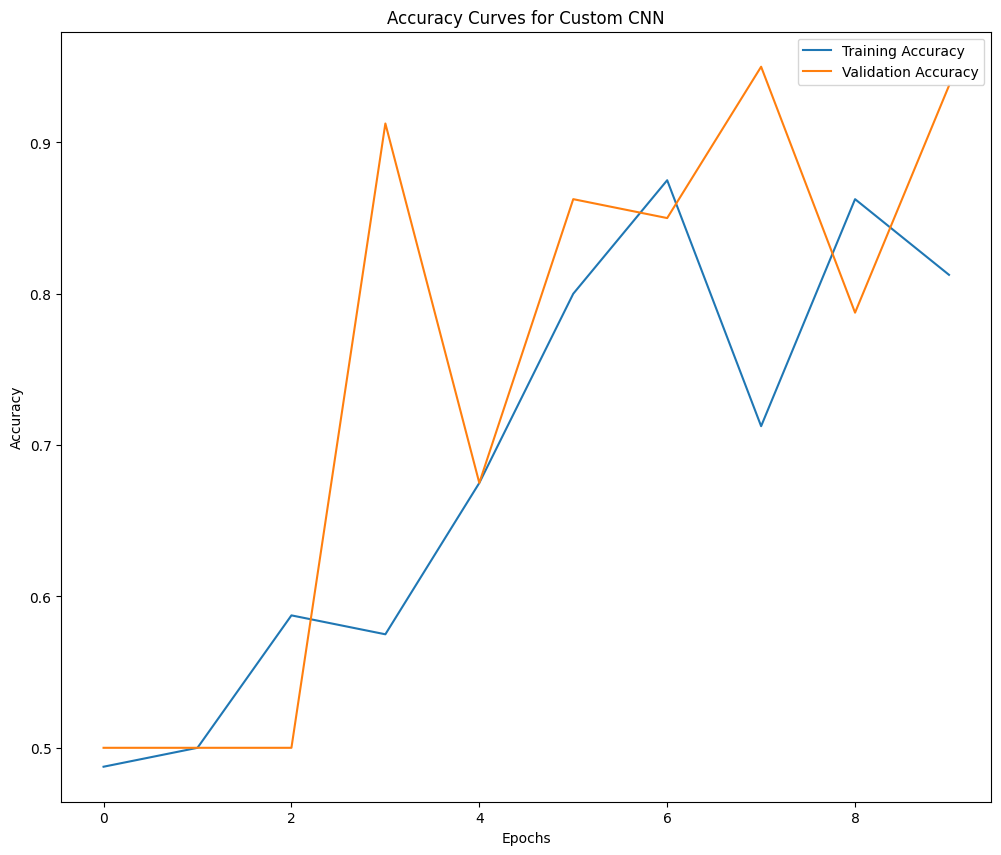

In [17]:
import matplotlib.pyplot as plt

# Plotting loss curves for custom CNN
plt.figure(figsize=(12, 10))
plt.title("Loss Curves for Custom CNN")
plt.plot(history_custom_cnn.history["loss"], label="Training Loss")
plt.plot(history_custom_cnn.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting accuracy curves for custom CNN
plt.figure(figsize=(12, 10))
plt.title("Accuracy Curves for Custom CNN")
plt.plot(history_custom_cnn.history["accuracy"], label="Training Accuracy")
plt.plot(history_custom_cnn.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

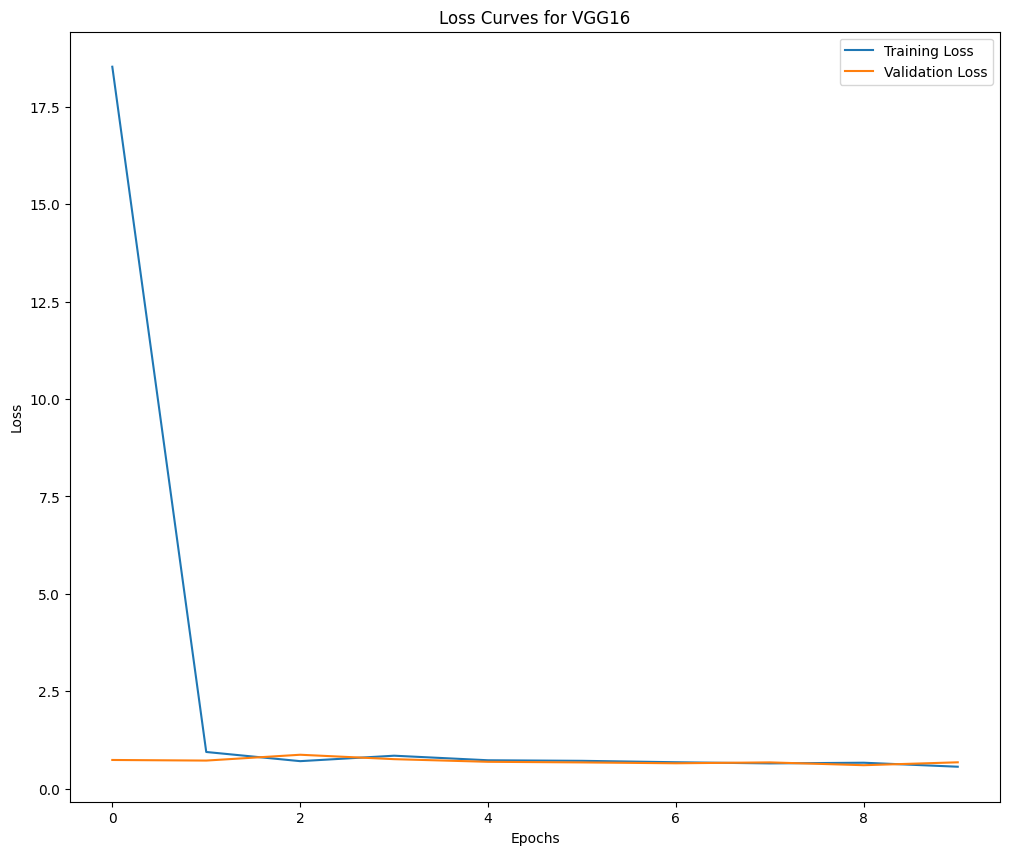

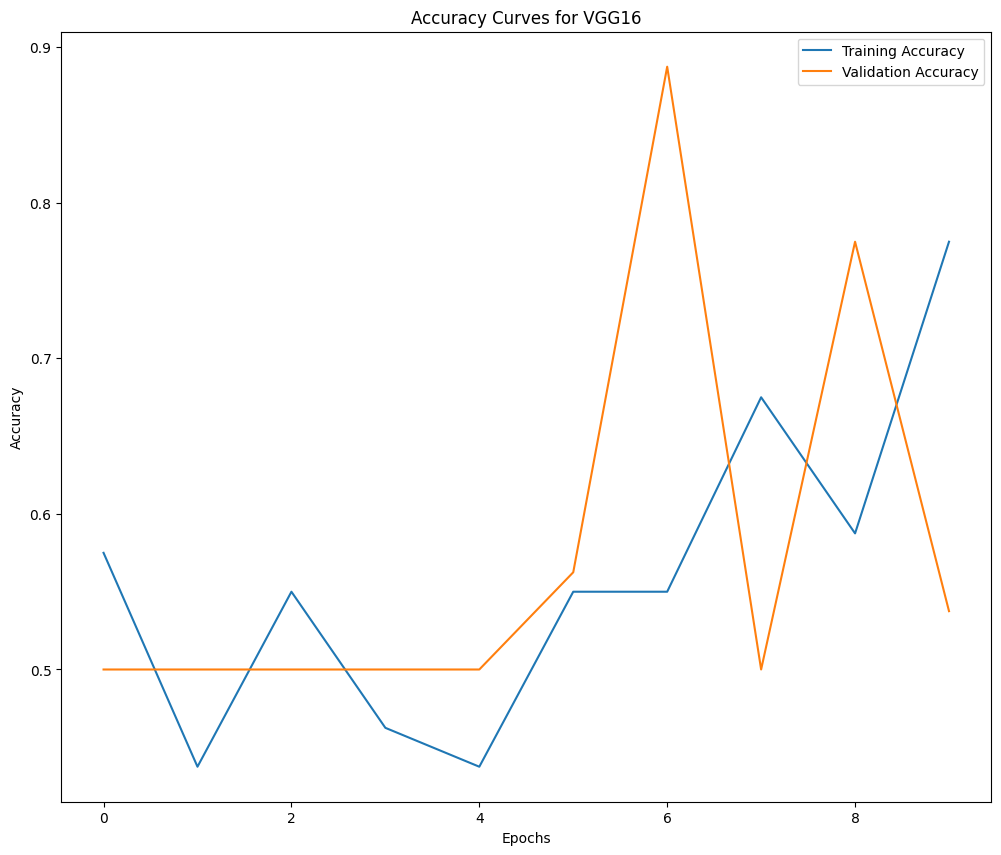

In [18]:
# Plotting loss curves for VGG16
plt.figure(figsize=(12, 10))
plt.title("Loss Curves for VGG16")
plt.plot(history_vgg16.history["loss"], label="Training Loss")
plt.plot(history_vgg16.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting accuracy curves for VGG16
plt.figure(figsize=(12, 10))
plt.title("Accuracy Curves for VGG16")
plt.plot(history_vgg16.history["accuracy"], label="Training Accuracy")
plt.plot(history_vgg16.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
# Creating a new generator for test data
test_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,  # Ubah batch_size menjadi 20
    class_mode='binary',  # Gunakan class_mode='binary'
    shuffle=False
)

Found 80 images belonging to 2 classes.


In [20]:
# Predicting labels for all test images using Custom CNN
y_pred_custom_cnn = custom_cnn.predict(test_generator)

4/4 [==============================] - 1s 272ms/step


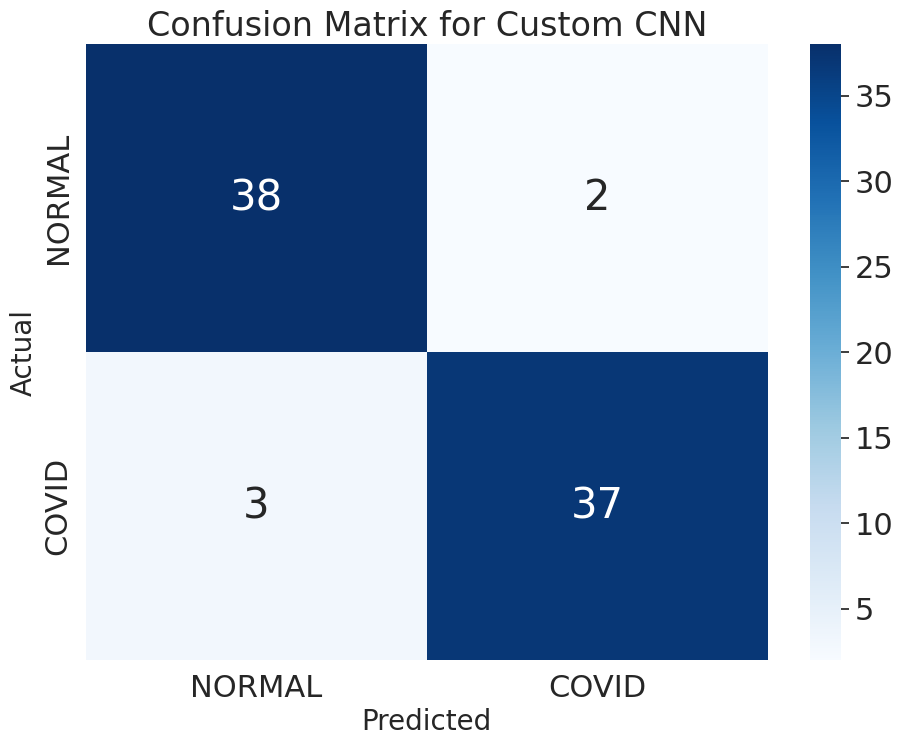

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting confusion matrix for Custom CNN
plt.figure(figsize=(11, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(validation_generator.classes, (y_pred_custom_cnn > 0.5).astype(int).ravel()),
            annot=True,
            annot_kws={"size": 30},
            fmt='g',
            cmap='Blues',
            xticklabels=['NORMAL', 'COVID'],
            yticklabels=['NORMAL', 'COVID'])
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix for Custom CNN')
plt.show()



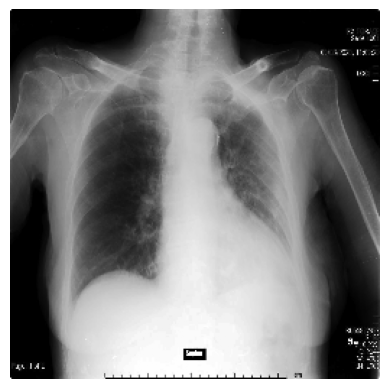

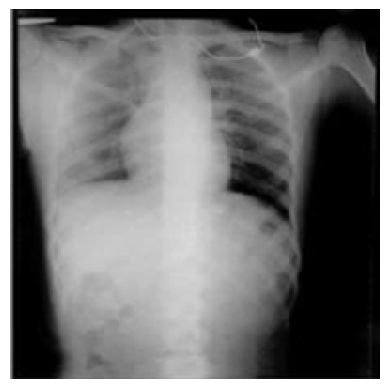

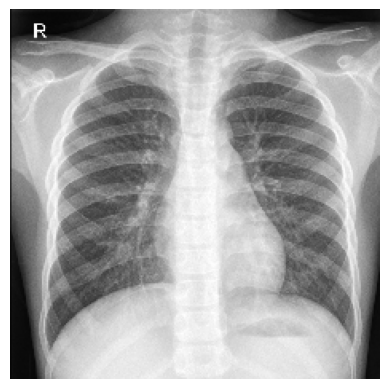

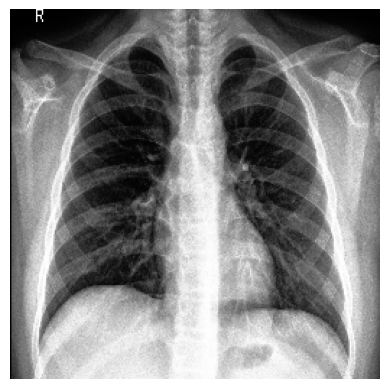

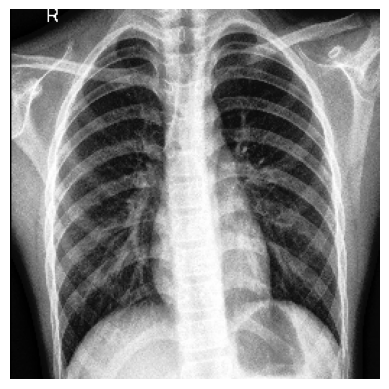

In [24]:
# Getting indices of wrongly classified images
misclassified_indices_custom_cnn = np.where(validation_generator.classes != (y_pred_custom_cnn > 0.5).astype(int).ravel())[0]

# Displaying all wrongly classified images for Custom CNN
for i in misclassified_indices_custom_cnn:
    image_path = test_generator.filepaths[i]
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [25]:
# Predicting labels for all test images using VGG16
y_pred_vgg16 = vgg16.predict(test_generator)

4/4 [==============================] - 33s 7s/step


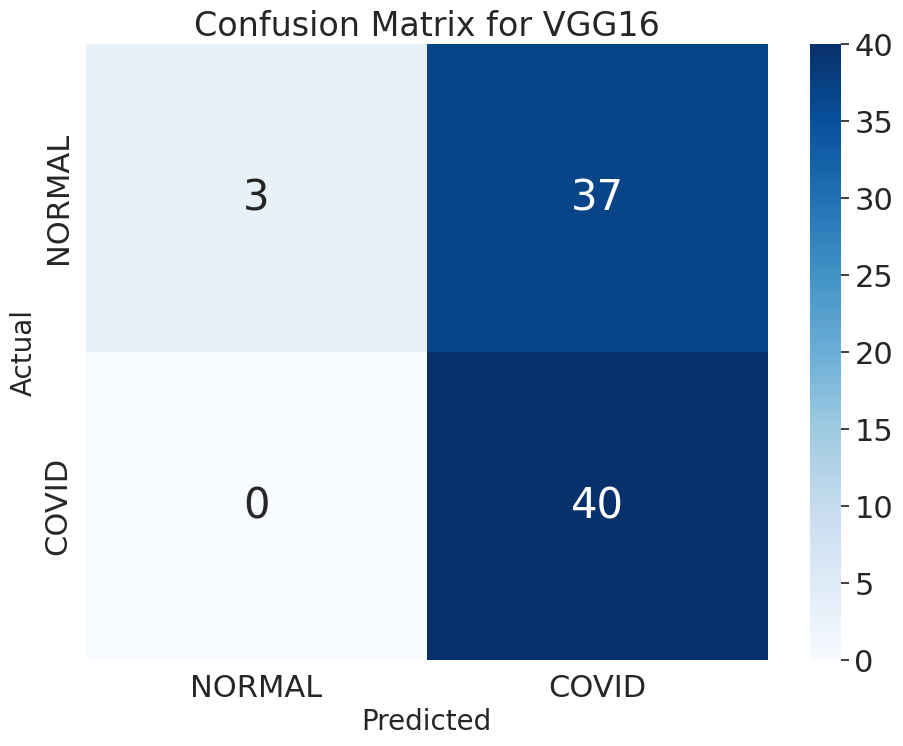

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting confusion matrix for VGG16
plt.figure(figsize=(11, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(validation_generator.classes, (y_pred_vgg16 > 0.5).astype(int).ravel()),
            annot=True,
            annot_kws={"size": 30},
            fmt='g',
            cmap='Blues',
            xticklabels=['NORMAL', 'COVID'],
            yticklabels=['NORMAL', 'COVID'])
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix for VGG16')
plt.show()


In [29]:
# Getting indices of wrongly classified images for VGG16
misclassified_indices_vgg16 = np.where(validation_generator.classes != (y_pred_vgg16 > 0.5).astype(int).ravel())[0]

In [30]:
# Displaying all wrongly classified images for VGG16
for i in misclassified_indices_vgg16:
    image_path = test_generator.filepaths[i]
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

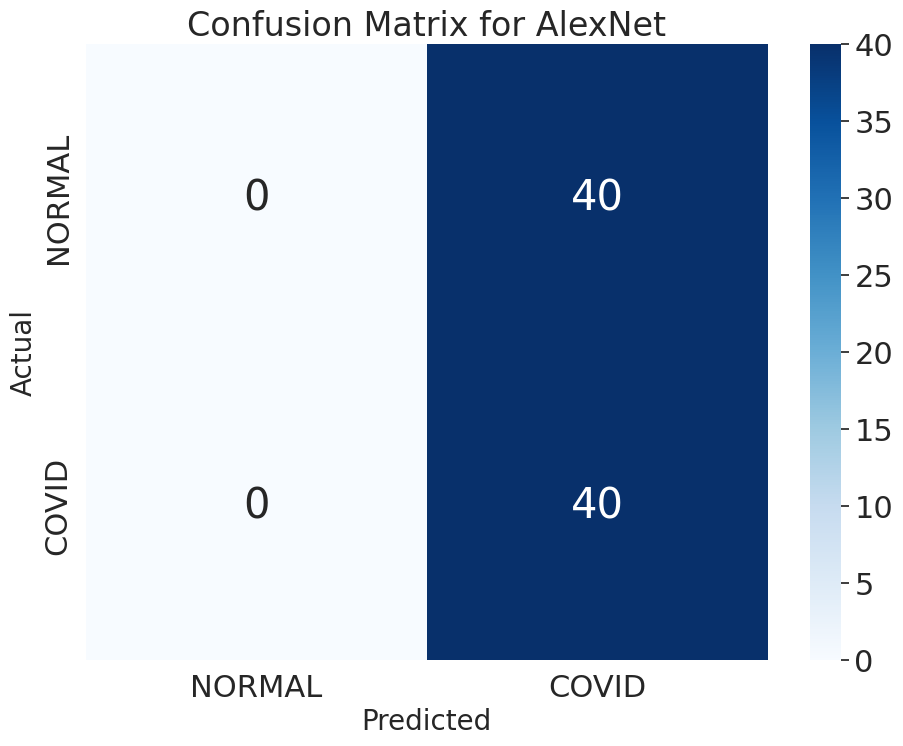

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting confusion matrix for AlexNet
plt.figure(figsize=(11, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(validation_generator.classes, (y_pred_alexnet > 0.5).astype(int).ravel()),
            annot=True,
            annot_kws={"size": 30},
            fmt='g',
            cmap='Blues',
            xticklabels=['NORMAL', 'COVID'],
            yticklabels=['NORMAL', 'COVID'])
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix for AlexNet')
plt.show()


In [32]:
# Getting indices of wrongly classified images for AlexNet
misclassified_indices_alexnet = np.where(validation_generator.classes != (y_pred_alexnet > 0.5).astype(int).ravel())[0]

In [33]:
# Displaying all wrongly classified images for AlexNet
for i in misclassified_indices_alexnet:
    image_path = validation_generator.filepaths[i]
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.